<a href="https://colab.research.google.com/github/heejvely/NLP_models/blob/main/BERT(Bidirectional_Encoder_Representations_from_Transformers)%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* 코드 참조: https://paul-hyun.github.io/bert-02/

# 0. Pip install
필요한 패키지를 pip를 이용해서 설치합니다.

In [1]:
!pip install sentencepiece
!pip install wget

     |████████████████████████████████| 1.2 MB 10.2 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=46c6574a411cb854edf66598e703c6cb6dffbefc03b92018ee93db10f17d0577
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
# gpu 설정
!nvidia-smi

Mon Jan  3 08:45:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Imports

In [3]:
import os
import numpy as np
import math
from random import random, randrange, randint, shuffle, choice
import matplotlib.pyplot as plt
import json
import pandas as pd
from IPython.display import display
from tqdm import tqdm, tqdm_notebook, trange
import sentencepiece as spm
import wget

import torch
import torch.nn as nn
import torch.nn.functional as F

# 2. Vocab 및 입력
Sentencepiece를 활용해 Vocab 만들기를 통해 만들어 놓은 vocab을 로딩합니다.

In [4]:
import sentencepiece as spm
# vocab loading
vocab_file = '/content/drive/MyDrive/colab/NLP_모델/kowiki_corpus/kowiki.model'
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

# 3. Config

- Transformer와 파라미터를 동일하게 설정
- BERT는 Encoder만 사용하므로 항목 중 Decoder 부분 제거
- 기본 입력에 추가로 segment 정보를 입력 받는데, Segment 수를 정의하는 n_seg_type을 추가로 정의

In [5]:
"""configuration json을 읽어들이는 class"""
class Config(dict):
  __getattr__ = dict.__getitem__
  __setarrt__ = dict.__setitem__

  @classmethod
  def load(cls, file):
    with open(file, 'r') as f:
      config = json.loads(f.read())
      return Config(config)

In [6]:
config = Config({
    'n_enc_vocab': len(vocab),
    'n_enc_seq': 256,
    'n_seg_type': 2,
    'n_layer': 6,
    'd_hidn': 256,
    'i_pad': 0,
    'd_ff': 1024,
    'n_head': 4,
    'd_head': 64,
    'dropout': 0.1,
    'layer_norm_epsilon': 1e-12
})
print(config)

{'n_enc_vocab': 8007, 'n_enc_seq': 256, 'n_seg_type': 2, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


# 4. Common Class
공통으로 사용되는 Class 및 함수

In [7]:
"""sinusoid position encoding"""
def get_sinusoid_encoding_table(n_seq, d_hidn):
  def cal_angle(position, i_hidn):
    return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
  def get_posi_angle_vec(position):
    return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

  sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])  # 1. 각 position별 hidden index별 angle 값을 구합니다.
  sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])                         # 2. hidden 짝수 index의 angle값의 sin값을 구합니다.
  sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])                         # 3. hidden 홀수 index의 angle값의 cos값을 구합니다.

  return sinusoid_table

"""attention pad mask"""
def get_attn_pad_mask(seq_q, seq_k, i_pad):
  batch_size, len_q = seq_q.size()
  batch_size, len_k = seq_k.size()
  pad_attn_mask = seq_k.data.eq(i_pad)                                              # 1. K의 값 중에 Pad인 부분을 True로 변경합니다.(나머지는 False)
  pad_attn_mask = pad_attn_mask.unsqueeze(1).expand(batch_size, len_q, len_k)       # 2. 구해진 값의 크기를 Q-len, K-len 되도록 변경합니다.
  return pad_attn_mask

"""attention decoder mask"""
def get_attn_decoder_mask(seq):
  subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1)) # 1. 모든 값이 1인 Q-len, K-leb 테이블을 생성합니다.
  subsequent_mask = subsequent_mask.triu(diagonal=1)                                                 # 2. 대각선을 기준으로 아래쪽을 0으로 만듭니다.
  return subsequent_mask

"""scale dot product attention"""
class ScaledDotProductAttention(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config
    self.dropout= nn.Dropout(config.dropout)
    self.scale = 1 / (self.config.d_head ** 0.5)

  def forward(self, Q, K, V, attn_mask):
    scores = torch.matmul(Q, K.transpose(-1, -2))     # 1. Q * K.transpose를 구합니다.
    scores = scores.mul_(self.scale)                   # 2. K-dimention에 루트를 취한 값으로 나눠 줍니다.
    scores.masked_fill_(attn_mask, -1e9)              # 3. Mask를 적용합니다.

    attn_prob = nn.Softmax(dim= -1)(scores)           # 4. Softmax를 취해 각 단어의 가중치 확률분포 attn_prob를 구합니다.
    attn_prob = self.dropout(attn_prob)               # 5. attn_prob * V를 구합니다. 구한 값은 Q에 대한 V의 가중치 합 벡터입니다.

    context = torch.matmul(attn_prob, V)

    return context, attn_prob

"""multi head attention"""
class MultiHeadAttention(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
    self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
    self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
    self.scaled_dot_attn = ScaledDotProductAttention(self.config)
    self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
    self.dropout = nn.Dropout(config.dropout)

  def forward(self, Q, K, V, attn_mask):
    batch_size = Q.size(0)
    q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)                   # 1. Q * W_Q를 한 후 multi-head로 나눕니다.
    k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)                   # 2. K * W_K를 한 후 multi-head로 나눕니다.
    v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)                   # 3. V * W_V를 한 후 multi-head로 나눕니다.

    attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)

    context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)                                             # 4. ScaledDotProductAttention 클래스를 이용해 각 head 별 Attention을 구합니다.
    context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)    # 5. 여러 개의 head를 1개로 합칩니다.
    output = self.linear(context)                                                                                   # 6. Linear를 취해 최종 Multi-Head Attention값을 구합니다.
    output = self.dropout(output)
    
    return output, attn_prob

"""feed forward"""
class PoswiseFeedForwardNet(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.conv1 = nn.Conv1d(in_channels = self.config.d_hidn, out_channels = self.config.d_ff, kernel_size=1)
    self.conv2 = nn.Conv1d(in_channels = self.config.d_ff, out_channels = self.config.d_hidn, kernel_size=1)
    self.active = F.gelu
    self.dropout = nn.Dropout(config.dropout)

  def forward(self, inputs):
    output = self.conv1(inputs.transpose(1, 2))     # 1. Linear를 실행하여 shape을 d_ff(hidden * 4)크기로 키웁니다.
    output = self.active(output)                    # 2. activation 함수(relu or gelu)를 실행합니다.

    output = self.conv2(output).transpose(1, 2)     # 3. Linear를 실행하여 shape을 hidden 크기로 줄입니다.
    output = self.dropout(output)

    return output

# 5. Encoder
BERT는 표준 Transformer의 Decoder는 사용하지 않고 Encoder만 사용합니다.

Position Embedding 학습, Segment Embedding 추가 두가지 이외에 나머지 부분은 표준 Transformer와 동일합니다.

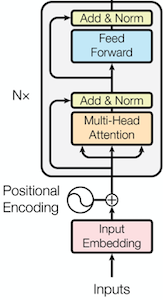

#### Encoder Layer
표준 Transformer EncoderLayer와 동일합니다.

In [8]:
"""encoder layer"""
class EncoderLayer(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.self_attn = MultiHeadAttention(self.config)
    self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps = self.config.layer_norm_epsilon)
    self.pos_ffn = PoswiseFeedForwardNet(self.config)
    self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps = self.config.layer_norm_epsilon)

  def forward(self, inputs, attn_mask):
    attn_outputs, attn_prob = self.self_attn(inputs, inputs, inputs,attn_mask)    # 1. Multi-Head Attention을 수행합니다. Q, K, V 모두 동일한 값을 사용하는 self-attention입니다.
    attn_outputs = self.layer_norm1(inputs + attn_outputs)                        # 2. 1번의 결과와 input(residual)을 더한 후 LayerNorm을 실행합니다.

    ffn_outputs = self.pos_ffn(attn_outputs)                                      # 3. 2번의 결과를 입력으로 Feed Forward를 실행합니다.
    ffn_outputs = self.layer_norm2(ffn_outputs + attn_outputs)                    # 4. 3번의 결과와 2번의 결과(residual)을 더한 후 LayerNorm을 실행합니다.

    return ffn_outputs, attn_prob

#### Encoder
표준 Transformer Encoder와 아래 내용이 다릅니다.

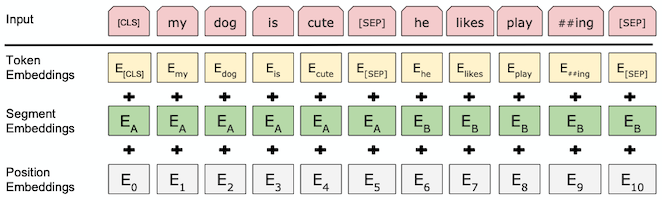

1. Position을 학습할 수 있도록 하였습니다.
  - 표준 Transformer에서는 sinusoid encoding을 구한 후 이 값으로 position embedding을 초기화 할 때 freeze 옵션을 True로 주어 Position embedding이 학습되지 않도록 하였습니다.
  - BERT는 position embedding을 기본 값으로 초기화 한 후 학습되도록 하였습니다.

2. Segment Embedding을 추가했습니다.
  - Segment Embedding은 위 그림과 같이 두개의 문장이 들어갈 경우 첫 번째 문장과 두번째 문장을 구분하기 위해 사용됩니다.

3. Encoder input에 Segment 정보를 추가했습니다.

4. Token, Position 및 Segment 3가지 Embedding을 더 합니다.
  - 표준 Transformer에서는 Token, Position 2가지 Embedding을 더 합니다.

나머지는 Transforemr Encoder와 동일합니다.

In [9]:
"""encoder"""
class Encoder(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
    self.pos_emb = nn.Embedding(self.config.n_enc_seq + 1, self.config.d_hidn)                      # 1. Position을 학습할 수 있도록 하였습니다.
    self.seg_emb = nn.Embedding(self.config.n_seg_type, self.config.d_hidn)                         # 2. Segment Embedding을 추가했습니다.

    self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_layer)])

  def forward(self, inputs, segments):                                                              # 3. Encoder input에 Segment 정보를 추가했습니다.
    positions = torch.arange(inputs.size(1), device = inputs.device, dtype = inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
    pos_mask = inputs.eq(self.config.i_pad)
    positions.masked_fill_(pos_mask, 0)

    outputs = self.enc_emb(inputs) + self.pos_emb(positions) + self.seg_emb(segments)               # 4. Token, Position 및 Segment 3가지 Embedding을 더 합니다.
   
    attn_mask = get_attn_pad_mask(inputs, inputs, self.config.i_pad)
    
    attn_probs = []
    for layer in self.layers:
      outputs, attn_prob = layer(outputs, attn_mask)
      attn_probs.append(attn_prob)
    
    return outputs, attn_probs

# 6. BERT
BERT 모델 클래스

1. BERT는 Transformer Encoder를 실행합니다.
2. 1번의 결과(outputs)의 첫 번째([CLS]) Token을 output_cls로 저장합니다.
3. outputs_cls에 Linear 및 tanh을 실행합니다.
4. Pretrain된 모델을 저장하기위한 save 함수입니다.
5. Pretrain된 모델을 읽기위한 load 함수 입니다.

In [10]:
"""bert"""
class BERT(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.encoder = Encoder(self.config)

    self.linear = nn.Linear(config.d_hidn, config.d_hidn)
    self.activation = torch.tanh

  def forward(self, inputs, segments):
    outputs, self_attn_probs = self.encoder(inputs, segments)     # 1. BERT는 Transformer Encoder를 실행합니다.

    outputs_cls = outputs[:, 0].contiguous()                      # 2. 1번의 결과(outputs)의 첫 번째([CLS]) Token을 output_cls로 저장합니다.
    outputs_cls = self.linear(outputs_cls)                        # 3. outputs_cls에 Linear 및 tanh을 실행합니다.
    outputs_cls = self.activation(outputs_cls)

    return outputs, outputs_cls, self_attn_probs

  def save(self, epoch, loss, path):                              # 4. Pretrain된 모델을 저장하기위한 save 함수입니다.
    torch.save({
        'epoch': epoch,
        'loss': loss,
        'state_dict': self.state_dict()
    }, path)

  def load(self, path):                                           # 5. Pretrain된 모델을 읽기위한 load 함수 입니다.
    save = torch.load(path)
    self.load_state_dict(save['state_dict'])
    return save['epoch'], save['loss']

# 7. Naver 영화 분류 모델

BERT 클래스를 이용하여 Naver 영화리뷰 감정분석 분류 모델 클래스를 아래와 같이 정의합니다.

1. inputs, segments를 입력으로 BERT 모델을 실행합니다.
2. 1번 결과의 outputs_cls 값을 Classification을 위한 값으로 사용합니다.

In [11]:
"""naver movie classification"""
class MovieClassification(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.bert = BERT(self.config)
    self.projection_cls = nn.Linear(self.config.d_hidn, self.config.n_output, bias = False)

  def forward(self, inputs, segments):
    outputs, outputs_cls, attn_probs = self.bert(inputs, segments)      # 1. inputs, segments를 입력으로 BERT 모델을 실행합니다.
    logits_cls = self.projection_cls(outputs_cls)                       # 2. 1번 결과의 outputs_cls 값을 Classification을 위한 값으로 사용합니다.
    return logits_cls, attn_probs

# 8. DataSet

#### DataSet
Naver 영화리뷰 감정분석 데이터 셋입니다.

1. 입력 파일로부터 'label'을 읽어 들입니다.
2. 입력파일로부터 'doc' token을 읽어 숫자(token id)로 변경합니다.
  - 시작은 '[CLS]' 끝은 '[SEP]'가 되도록 합니다.
3. segment(0)를 생성합니다.

In [12]:
""" 영화 분류 데이터셋 """
class MovieDataSet(torch.utils.data.Dataset):
  def __init__(self, vocab, infile):
    self.vocab = vocab
    self.labels = []
    self.sentences = []
    self.segments = []

    line_cnt = 0
    with open(infile, 'r') as f:
      for line in f:
        line_cnt += 1

    with open(infile, 'r') as f:
      for i, line in enumerate(tqdm(f, total=line_cnt, desc='Loading Dataset', unit=' lines')):
        data = json.loads(line)
        self.labels.append(data['label'])                 # 1. 입력 파일로부터 'label'을 읽어 들입니다.

        # 2. 입력파일로부터 'doc' token을 읽어 숫자(token id)로 변경합니다.
        sentence = [vocab.piece_to_id('[CLS]')] + [vocab.piece_to_id(p) for p in data['doc']] + [vocab.piece_to_id('[SEP]')]
        self.sentences.append(sentence)
        self.segments.append([0] * len(sentence))         # 3. segment(0)를 생성합니다.

  def __len__(self):
    assert len(self.labels) == len(self.sentences)
    assert len(self.labels) == len(self.segments)
    return len(self.labels)

  def __getitem__(self, item):
    return (torch.tensor(self.labels[item]),
            torch.tensor(self.sentences[item]),
            torch.tensor(self.segments[item]))

#### collate_fn
배치단위로 데이터 처리를 위한 collate_fn

1. inputs의 길이가 같아지도록 짧은 문장에 padding(0)을 추가합니다.
  - padding은 Sentencepiece를 활용해 Vocab 만들기에서 '-pad_id=0' 옵션으로 지정한 값입니다.
2. segments의 길이가 같아지도록 짧은 문장에 padding(0)을 추가합니다.
3. Label은 길이가 1 고정이므로 stack 함수를 이용해 tensor로 만듭니다.

In [13]:
"""movie data collate_fn"""
def movie_collate_fn(inputs):
  labels, inputs, segments = list(zip(*inputs))

  inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value = 0)     # 1. inputs의 길이가 같아지도록 짧은 문장에 padding(0)을 추가합니다.
  segments = torch.nn.utils.rnn.pad_sequence(segments, batch_first=True, padding_value = 0) # 2. segments의 길이가 같아지도록 짧은 문장에 padding(0)을 추가합니다.
  batch = [
           torch.stack(labels, dim=0),                                                      # 3. Label은 길이가 1 고정이므로 stack 함수를 이용해 tensor로 만듭니다.
           inputs,
           segments
  ]
  return batch

#### DataLoader
위에서 정의한 DataSet과 collate_fn을 이용해 학습용(train_loader), 평가용(test_lader) DataLoader를 만듭니다.

In [14]:
"""데이터 로더"""
batch_size = 128
train_dataset = MovieDataSet(vocab, '/content/drive/MyDrive/colab/NLP_모델/naver_sentiment_corpus/ratings_train.json')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle = True, collate_fn = movie_collate_fn)
test_dataset = MovieDataSet(vocab, '/content/drive/MyDrive/colab/NLP_모델/naver_sentiment_corpus/ratings_test.json')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle = True, collate_fn = movie_collate_fn)

Loading Dataset: 100%|██████████| 49997/49997 [00:01<00:00, 25464.10 lines/s]


# 9. Evaluate
- 학습된 MoviedClassification 모델의 성능을 평가하기 위한 함수
- 평가는 정확도(accuracy)를 사용

1. inputs, segments를 입력으로 MovieClassification을 실행합니다.
2. 1번의 결과 중 첫번째 값이 예측 logits입니다.
3. logits의 최대값의 index를 구합니다.
4. 3번에서 구한 값과 labels의 값이 같은지 비교합니다.

In [15]:
"""모델 epoch 평가"""
def eval_epoch(config, model, data_loader):
  matchs = []
  model.eval()

  n_word_total = 0
  n_correct_total = 0
  with tqdm(total=len(data_loader), desc=f'Valid') as pbar:
    for i, value in enumerate(data_loader):
      labels, inputs, segments = map(lambda v: v.to(config.device), value)

      outputs = model(inputs, segments)                                   # 1. inputs, segments를 입력으로 MovieClassification을 실행합니다.
      logits_cls = outputs[0]                                             # 2. 1번의 결과 중 첫번째 값이 예측 logits입니다.
      _, indices = logits_cls.max(1)                                      # 3. logits의 최대값의 index를 구합니다.

      match = torch.eq(indices, labels).detach()                          # 4. 3번에서 구한 값과 labels의 값이 같은지 비교합니다.
      matchs.extend(match.cpu())
      accuracy = np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

      pbar.update(1)
      pbar.set_postfix_str(f'Acc: {accuracy:.3f}')
  return np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

# 10. Train
MovieClassification 모델을 학습하기 위한 함수입니다.

1. inputs, segments를 입력으로 MovieClassification을 실행합니다.
2. 1번의 결과 중 첫 번째 값이 예측 logits입니다.
3. logits 값과 labels의 값을 이용해 Loss를 계산합니다.
4. loss, optimizer를 이용해 학습합니다.

In [16]:
"""모델 epoch 학습"""
def train_epoch(config, epoch, model, criterion_cls, optimizer, train_loaer):
  losses = []
  model.train()

  with tqdm(total=len(train_loader), desc = f'Train({epoch})') as pbar:
    for i, value in enumerate(train_loader):
      labels, inputs, segments = map(lambda v: v.to(config.device), value)

      optimizer.zero_grad()
      outputs = model(inputs, segments)                          # 1. inputs, segments를 입력으로 MovieClassification을 실행합니다.
      logits_cls = outputs[0]                                    # 2. 1번의 결과 중 첫 번째 값이 예측 logits입니다.

      loss_cls = criterion_cls(logits_cls, labels)               # 3. logits 값과 labels의 값을 이용해 Loss를 계산합니다.
      loss = loss_cls
                              
      loss_val = loss.item()
      losses.append(loss_val)

      loss.backward()                                            # 4. loss, optimizer를 이용해 학습합니다.
      optimizer.step()

      pbar.update(1)
      pbar.set_postfix_str(f'Loss: {loss_val:.3f} ({np.mean(losses):.3f}')
  return np.mean(losses)

학습을 위한 추가적인 내용을 선언합니다.

1. GPU 사용 여부를 확인합니다.
2. 출력 값 개수를 정의합니다.(부정(0), 긍정(1) 2가지입니다.)
3. learning_rate 및 학습 epoch를 선언합니다.

In [17]:
config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    # 1. GPU 사용 여부를 확인합니다.
config.n_output = 2                                                             # 2. 출력 값 개수를 정의합니다.(부정(0), 긍정(1) 2가지입니다.)
print(config)

learning_rate = 5e-5                                                            # 3. learning_rate 및 학습 epoch를 선언합니다.
n_epoch = 10

{'n_enc_vocab': 8007, 'n_enc_seq': 256, 'n_seg_type': 2, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


위에서 선언된 내용을 이용해 학습을 실행하는 함수입니다.

1. MovieClassification이 GPU 또는 CPU를 지원하도록 합니다.
2. loss 함수를 선언합니다.
3. optimizer를 선언합니다.
4. 각 epoch 마다 학습을 합니다.
5. 각 epoch 마다 평가를 합니다.

In [18]:
def train(model):
  model.to(config.device)                                                               # 1. MovieClassification이 GPU 또는 CPU를 지원하도록 합니다.

  criterion_cls = torch.nn.CrossEntropyLoss()                                           # 2. loss 함수를 선언합니다.
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)                    # 3. optimizer를 선언합니다.

  best_epoch, best_loss, best_score = 0, 0, 0
  losses, scores = [], []
  for epoch in range(n_epoch):
    loss = train_epoch(config, epoch, model, criterion_cls, optimizer, train_loader)    # 4. 각 epoch 마다 학습을 합니다.
    score = eval_epoch(config, model, test_loader)                                      # 5. 각 epoch 마다 평가를 합니다.

    losses.append(loss)
    scores.append(score)

    if best_score < score:
      best_epoch, best_loss, best_score = epoch, loss, score
  print(f'>>>> epoch={best_epoch}, loss={best_loss:.5f}, score={best_score:.5f}')
  return losses, scores

#### Train(No Pretrain)
Pretrain을 사용하지 않고 학습을 진행합니다.

1. MovieClassification을 생성합니다.
2. 추가적인 처리없이 생성된 MovieClassification으로 학습을 진행합니다.

In [19]:
# 약 40분 소요
model = MovieClassification(config)
losses_00, scores_00 = train(model)

Valid: 100%|██████████| 391/391 [00:39<00:00,  9.81it/s, Acc: 0.813]


>>>> epoch=8, loss=0.31150, score=0.81593


#### Train(5 epoch Pretrain)

5 epoch Pretrain된 모델을 이용해 학습을 진행합니다.(참조 코드는 epoch 20)

1. MovieClassification을 생성합니다.
2. BERT(Bidirectional Encoder Representations from Transformers) 구현하기_1 에서 Pretrain 모델을 로드 합니다. 
3. MovieClassification으로 학습을 진행합니다.

In [20]:
# 약 40분 소요
model = MovieClassification(config)

save_pretrain = '/content/drive/MyDrive/colab/NLP_모델/BERT/save_bert_pretrain.pth'
model.bert.load(save_pretrain)

losses_05, scores_05 = train(model)

Valid: 100%|██████████| 391/391 [00:39<00:00,  9.86it/s, Acc: 0.818]


>>>> epoch=7, loss=0.29944, score=0.82127


# 11. Result

학습결과 및 평가결과는 아래와 같습니다.

Pretrain을 안한 경우는 정확도(score)가 81.3%정도 나왔습니다.

Pretrain을 5 epoch 한 경우는 정확도(socre)가 81.7%정도 나왔습니다.

,loss_00,score_00,loss_05,score_05
0,0.517969,0.777607,0.516642,0.774906
1,0.434667,0.796988,0.428195,0.802328
2,0.408886,0.805148,0.397082,0.804388
3,0.388349,0.805188,0.373587,0.816549
4,0.372887,0.811729,0.354034,0.818929
5,0.357846,0.813809,0.336197,0.818809
6,0.343571,0.815549,0.318232,0.818249
7,0.327491,0.815869,0.299437,0.821269
8,0.311502,0.815929,0.281233,0.821069
9,0.293657,0.813409,0.263326,0.817969


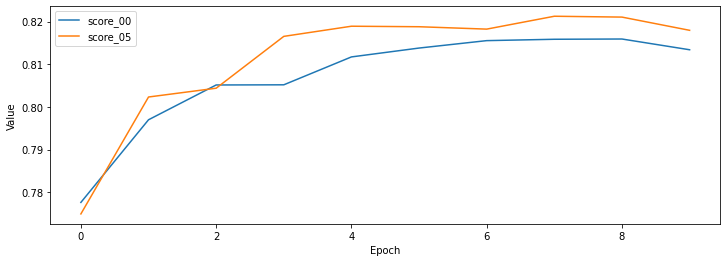

In [21]:
# table
data = {
    'loss_00': losses_00,
    'score_00': scores_00,
    'loss_05': losses_05,
    'score_05': scores_05
}

df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12,4])
plt.plot(scores_00, label = 'score_00')
plt.plot(scores_05, label='score_05')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()